## Humanities Digital Archives Project, Part 2 Topic Modeling
Shruti Gupta, Lisa Over, L. Sooter

In [125]:
import warnings;
warnings.filterwarnings('ignore');

In [126]:
# Import libraries
import csv
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import os
import nltk

# spacy for lemmatization
import spacy

import re
import contractions
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

# Gensim
import gensim
from gensim.models import word2vec
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint

## Read data from file

In [3]:
# Load data
pd.set_option('display.max_columns', None)
data_tsne = pd.read_csv('for_models_items.csv', encoding='latin-1')

# Display the head
data_tsne.head()

,Unnamed: 0,Unnamed: 0.1,Identifier,Title,Creator,Sort Date,Type of Resource,Genre,Abstract,Source,Site Membership,Collection Membership,Ttle_Abs,Abstract_cspell,Abstract_noc,Abstract_clean,Abstract_lemma
0,0,0,000001.PIC,Musicians,Paul Slantis,1950-01-01T00:00:00,still image,photograph,Six young African-American males playing percu...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,Musicians. Six young African-American males pl...,musicians. six young african-american males pl...,musicians. six young african-american males pl...,musicians six young african american males pla...,musician six young african american male play ...
1,1,1,000001.UE,Sylvania Locals Conference,United Electrical Workers,1945-04-29T00:00:00,still image,photograph,Leaders of Sylvania Locals. Front row (L-R): L...,"UE News Photograph Collection, 1933-1998UE New...","HistPitt, Digital",collection.89,Sylvania Locals Conference. Leaders of Sylvani...,sylvania locals conference. leaders of sylvani...,sylvania locals conference. leaders of sylvani...,sylvania locals conference leaders sylvania lo...,sylvania local conference leader sylvania loca...
2,2,2,000002.PIC,USMC Pilot with McDonnell FH Phantom,Paul Slantis,1950-01-01T00:00:00,still image,photograph,United States Marine Corps pilot with his McDo...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,USMC Pilot with McDonnell FH Phantom. United S...,usmc pilot with mcdonnell fh phantom. united s...,usmc pilot with mcdonnell fh phantom. united s...,usmc pilot mcdonnell fh phantom united states ...,usmc pilot mcdonnell fh phantom united state m...
3,3,3,000002.UE,Soup Kitchen,United Electrical Workers,1940-01-01T00:00:00,still image,photograph,Drinking donated coffee at Johnsonburg Plant S...,"UE News Photograph Collection, 1933-1998UE New...","HistPitt, Digital",collection.89,Soup Kitchen. Drinking donated coffee at Johns...,soup kitchen. drinking donated coffee at johns...,soup kitchen. drinking donated coffee at johns...,soup kitchen drinking donated coffee johnsonbu...,soup kitchen drink donate coffee johnsonburg p...
4,4,4,000003.PIC,Greater Pittsburgh International Airport Opening,Paul Slantis,1952-05-31T00:00:00,still image,photograph,US Navy airplanes lined up on the tarmac of th...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,Greater Pittsburgh International Airport Openi...,greater pittsburgh international airport openi...,greater pittsburgh international airport openi...,greater pittsburgh international airport openi...,great pittsburgh international airport open un...


In [16]:
data_tsne['Abstract'].isnull().sum()

73728

## Visualize Word Vectors with T-SNE

https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

In [17]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['Abstract_lemma']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split()
            corpus.append(word_list)
            
    return corpus

In [18]:
corpus = build_corpus(data_tsne)        
corpus[0:2]

[['musician',
  'six',
  'young',
  'african',
  'american',
  'male',
  'play',
  'percussion',
  'instrument'],
 ['sylvania',
  'local',
  'conference',
  'leader',
  'sylvania',
  'local',
  'front',
  'row',
  'l',
  'r',
  'local',
  '291',
  'business',
  'agent',
  'charle',
  'rackliffe',
  'local',
  '291',
  'president',
  'eileen',
  'dooley',
  'executive',
  'board',
  'member',
  'ruth',
  'edward',
  'huntington',
  'west',
  'virginia',
  'local',
  '608',
  'vice',
  'president',
  'jam',
  'simms',
  'back',
  'row',
  'l',
  'r',
  'executive',
  'board',
  'altoona',
  'local',
  '611',
  'member',
  'helen',
  'long',
  'local',
  '501',
  'jerrold',
  'mooney',
  'colonial',
  'radio',
  'buffalo',
  'altoona',
  'local',
  '611',
  'president',
  'ethel',
  'winter']]

In [19]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv['member']

array([-0.77868503,  2.6144    ,  0.4425947 ,  0.49349976, -0.35747704,
       -1.0822474 ,  0.20067738, -1.0794368 , -3.0893276 , -0.22598624,
       -0.21785451, -1.3812995 , -1.3430912 ,  1.6614339 , -2.285115  ,
       -1.5371716 , -0.81580865, -0.27701828,  1.0677638 ,  0.7502792 ,
        0.97462094, -0.06731039,  2.361098  ,  0.15627941, -2.2614863 ,
       -1.4165331 ,  1.555285  ,  0.5595172 , -0.95994323,  1.7839298 ,
       -0.0907492 , -1.1103009 , -0.5373985 , -0.26235628, -0.32182047,
       -0.317373  ,  1.0762221 ,  0.9819545 ,  0.8786487 ,  0.87833524,
       -0.22787155,  0.5397544 ,  0.11862242,  0.25139993, -0.67756253,
        1.3984987 , -0.15048303, -3.4887197 ,  0.13488737,  0.46109313,
       -1.1542462 ,  1.6754861 ,  1.2734009 , -1.0442649 ,  0.9720732 ,
        0.5580611 , -0.8245959 ,  0.33242375,  0.35724914, -0.29919618,
        0.83613867, -0.33365282, -0.17817375,  0.05180283, -1.2232016 ,
       -1.3716521 ,  0.2608264 , -0.06907835, -1.5277439 ,  0.91

In [36]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig('presentation/tsne.png')
    plt.show()

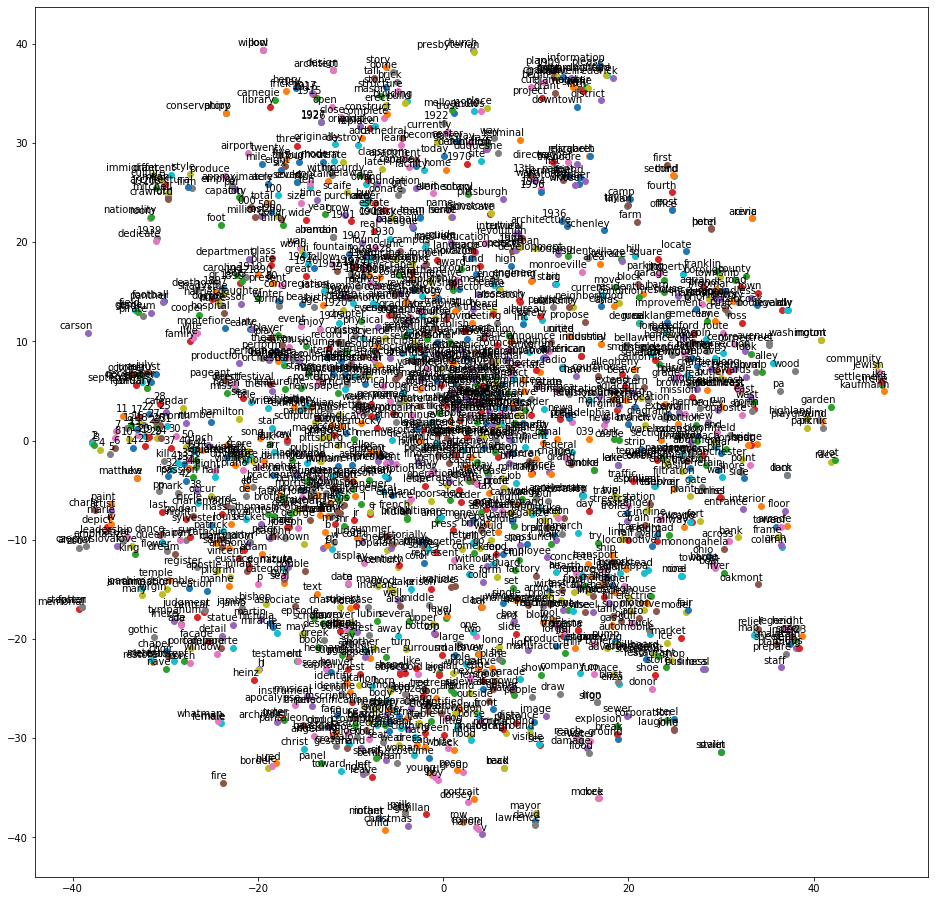

In [21]:
tsne_plot(model)

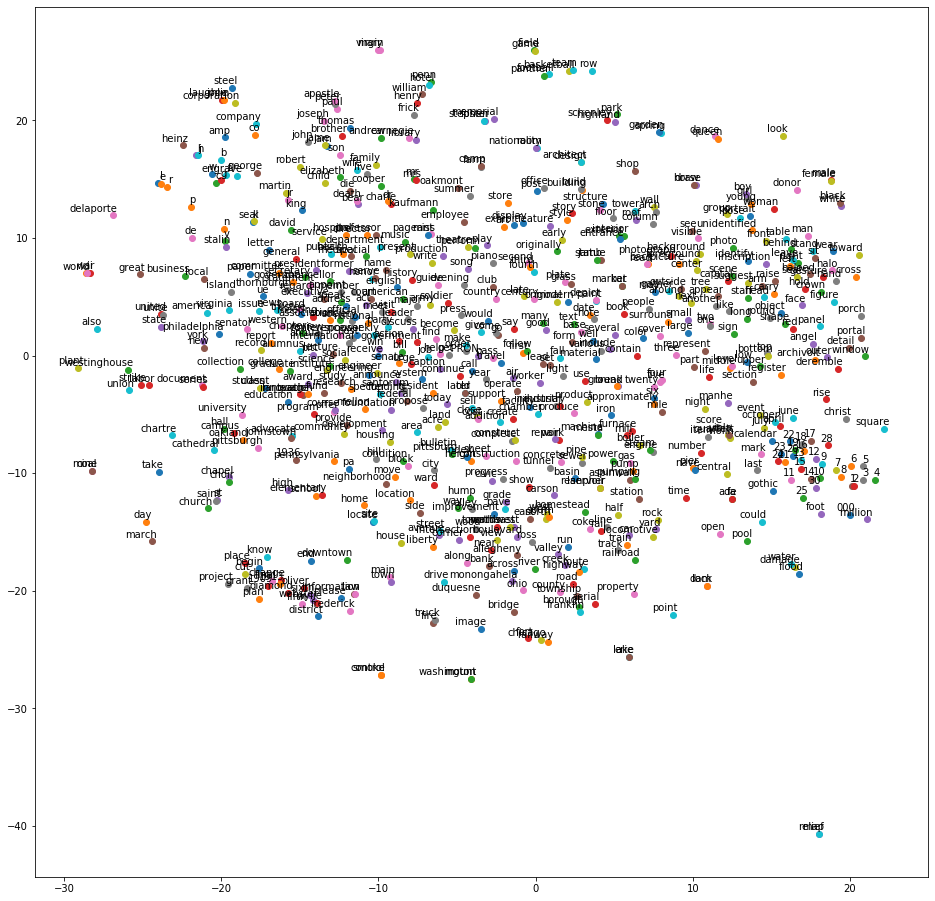

In [37]:
# A more selective model
model2 = word2vec.Word2Vec(corpus, size=100, window=20, min_count=500, workers=4)
tsne_plot(model2)

In [31]:
model2.most_similar('pittsburgh')

[('oakland', 0.5654544234275818),
 ('locate', 0.415157675743103),
 ('frederick', 0.40792620182037354),
 ('johnstown', 0.3937488794326782),
 ('facility', 0.3622789680957794),
 ('elementary', 0.35942932963371277),
 ('build', 0.35825902223587036),
 ('duquesne', 0.3560416102409363),
 ('street', 0.3516572117805481),
 ('ward', 0.34002095460891724)]

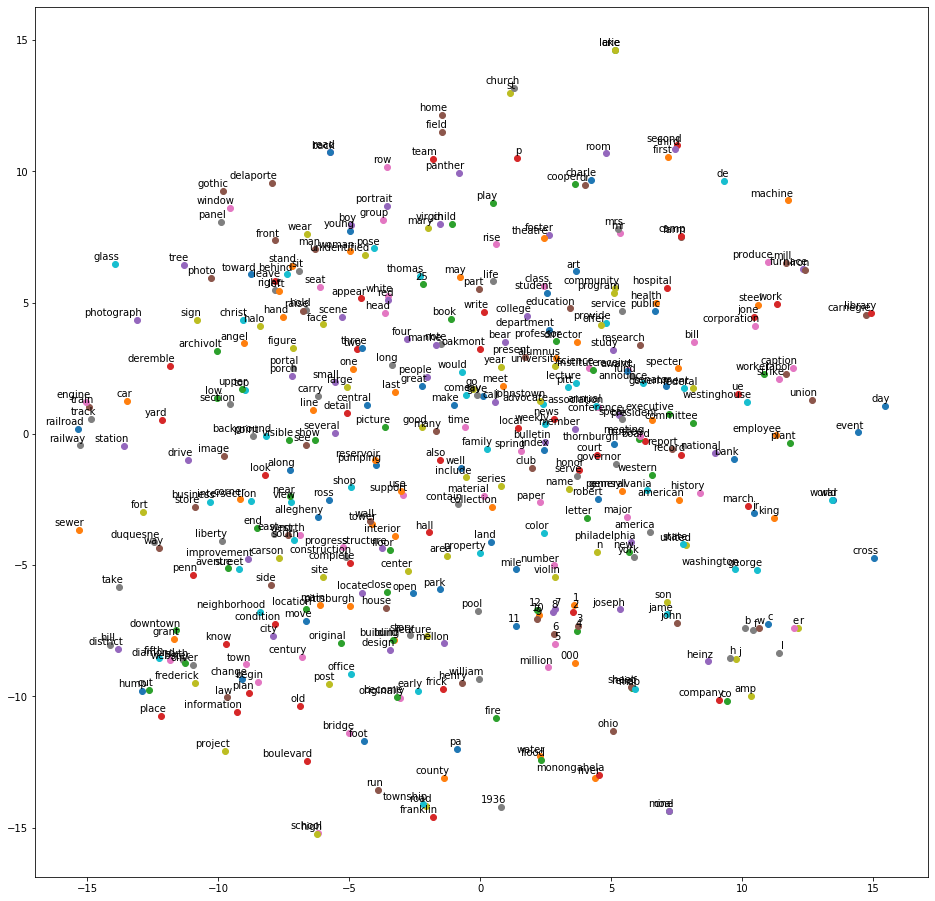

In [33]:
# A even more selective model
model3 = word2vec.Word2Vec(corpus, size=100, window=60, min_count=800, workers=4)
tsne_plot(model3)

In [94]:
edu = pd.DataFrame(model3.most_similar('education'), columns=['education', 'prob'])
edu.to_csv(r'presentation/tsne_edu.csv')
print(edu)

    education      prob
0   professor  0.608096
1     student  0.601517
2     college  0.590768
3       award  0.574205
4       offer  0.553818
5       study  0.537021
6        fund  0.528409
7  department  0.527123
8     alumnus  0.519636
9     program  0.502206


In [93]:
dntwn = pd.DataFrame(model3.most_similar('downtown'), columns=['downtown', 'prob'])
dntwn.to_csv(r'presentation/tsne_dntwn.csv')
print(dntwn)

    downtown      prob
0      grant  0.736048
1      sixth  0.685880
2    diamond  0.626533
3    webster  0.607311
4      fifth  0.555791
5     avenue  0.541849
6   building  0.540889
7     street  0.538637
8  frederick  0.538203
9       hump  0.534787


In [92]:
labr = pd.DataFrame(model3.most_similar('labor'), columns=['labor', 'prob'])
labr.to_csv(r'presentation/tsne_labor.csv')
print(labr)

        labor      prob
0      strike  0.737978
1     caption  0.718607
2  government  0.570379
3      worker  0.544239
4          ue  0.512321
5         war  0.416621
6       would  0.410374
7     specter  0.397564
8     support  0.385206
9        sign  0.374715


In [91]:
stl = pd.DataFrame(model3.most_similar('steel'), columns=['steel', 'prob'])
stl.to_csv(r'presentation/tsne_steel.csv')
print(stl)

         steel      prob
0         jone  0.647640
1  corporation  0.608312
2      furnace  0.562381
3         mill  0.559420
4      produce  0.557339
5         work  0.529123
6         iron  0.471290
7      company  0.453710
8        river  0.447893
9  monongahela  0.435195


In [90]:
panthr = pd.DataFrame(model3.most_similar('panther'), columns=['panther', 'prob'])
panthr.to_csv(r'presentation/tsne_panther.csv')
print(panthr)

      panther      prob
0        team  0.521773
1      weekly  0.406319
2       field  0.404863
3    portrait  0.387401
4        foot  0.364341
5        play  0.338815
6     alumnus  0.336803
7  university  0.314511
8        pitt  0.312076
9        long  0.298535


In [89]:
home = pd.DataFrame(model3.most_similar('home'), columns=['home', 'prob'])
home.to_csv(r'presentation/tsne_home.csv')
print(home)

           home      prob
0         field  0.575572
1         house  0.490149
2          site  0.487676
3      location  0.476280
4         serve  0.443000
5          move  0.439168
6  neighborhood  0.362804
7       provide  0.359423
8          camp  0.357699
9          open  0.348490


In [87]:
amer = pd.DataFrame(model3.most_similar('america'), columns=['america', 'prob'])
amer.to_csv(r'presentation/tsne_amer.csv')
print(amer)

        america      prob
0         state  0.529417
1           map  0.500807
2         major  0.487434
3          york  0.484194
4        united  0.470437
5        relief  0.468129
6  philadelphia  0.459256
7        letter  0.410187
8        portal  0.400986
9          note  0.361082


In [88]:
goth = pd.DataFrame(model3.most_similar('gothic'), columns=['gothic', 'prob'])
goth.to_csv(r'presentation/tsne_goth.csv')
print(goth)

   gothic      prob
0  window  0.436767
1  figure  0.395062
2  portal  0.369210
3  appear  0.344205
4  christ  0.340401
5   scene  0.333386
6     two  0.325403
7   panel  0.318127
8      st  0.314020
9    hold  0.310549


In [95]:
bridg = pd.DataFrame(model3.most_similar('bridge'), columns=['bridge', 'prob'])
bridg.to_csv(r'presentation/tsne_bridg.csv')
print(bridg)

         bridge      prob
0          foot  0.573540
1          fort  0.488669
2         river  0.475295
3  construction  0.474114
4   monongahela  0.435724
5         point  0.399020
6      original  0.396249
7      complete  0.385716
8       railway  0.376054
9     structure  0.372171


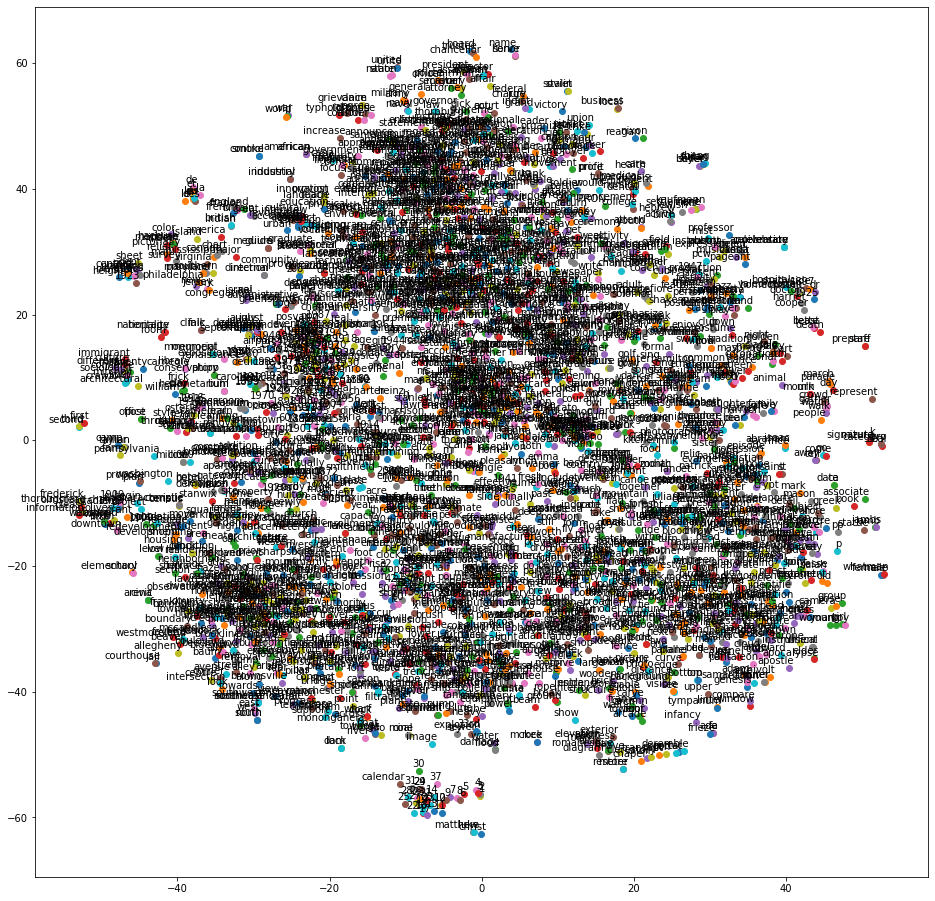

In [35]:
# A less selective model
model4 = word2vec.Word2Vec(corpus, size=100, window=20, min_count=100, workers=4)
tsne_plot(model4)

In [25]:
model4.most_similar('towboat')

[('barge', 0.8816713690757751),
 ('boat', 0.7508858442306519),
 ('dock', 0.7142809629440308),
 ('fleet', 0.6704373955726624),
 ('monongahela', 0.6375946402549744),
 ('rankin', 0.6371486783027649),
 ('vesta', 0.623248815536499),
 ('coal', 0.6060481071472168),
 ('ohio', 0.6047483682632446),
 ('mississippi', 0.5968846082687378)]

## Read clean data from file

In [42]:
# Load data
pd.set_option('display.max_columns', None)
data_lda = pd.read_csv('for_models_items.csv', encoding='latin-1')

# Display the head
data_lda.head()

,Unnamed: 0,Unnamed: 0.1,Identifier,Title,Creator,Sort Date,Type of Resource,Genre,Abstract,Source,Site Membership,Collection Membership,Ttle_Abs,Abstract_cspell,Abstract_noc,Abstract_clean,Abstract_lemma
0,0,0,000001.PIC,Musicians,Paul Slantis,1950-01-01T00:00:00,still image,photograph,Six young African-American males playing percu...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,Musicians. Six young African-American males pl...,musicians. six young african-american males pl...,musicians. six young african-american males pl...,musicians six young african american males pla...,musician six young african american male play ...
1,1,1,000001.UE,Sylvania Locals Conference,United Electrical Workers,1945-04-29T00:00:00,still image,photograph,Leaders of Sylvania Locals. Front row (L-R): L...,"UE News Photograph Collection, 1933-1998UE New...","HistPitt, Digital",collection.89,Sylvania Locals Conference. Leaders of Sylvani...,sylvania locals conference. leaders of sylvani...,sylvania locals conference. leaders of sylvani...,sylvania locals conference leaders sylvania lo...,sylvania local conference leader sylvania loca...
2,2,2,000002.PIC,USMC Pilot with McDonnell FH Phantom,Paul Slantis,1950-01-01T00:00:00,still image,photograph,United States Marine Corps pilot with his McDo...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,USMC Pilot with McDonnell FH Phantom. United S...,usmc pilot with mcdonnell fh phantom. united s...,usmc pilot with mcdonnell fh phantom. united s...,usmc pilot mcdonnell fh phantom united states ...,usmc pilot mcdonnell fh phantom united state m...
3,3,3,000002.UE,Soup Kitchen,United Electrical Workers,1940-01-01T00:00:00,still image,photograph,Drinking donated coffee at Johnsonburg Plant S...,"UE News Photograph Collection, 1933-1998UE New...","HistPitt, Digital",collection.89,Soup Kitchen. Drinking donated coffee at Johns...,soup kitchen. drinking donated coffee at johns...,soup kitchen. drinking donated coffee at johns...,soup kitchen drinking donated coffee johnsonbu...,soup kitchen drink donate coffee johnsonburg p...
4,4,4,000003.PIC,Greater Pittsburgh International Airport Opening,Paul Slantis,1952-05-31T00:00:00,still image,photograph,US Navy airplanes lined up on the tarmac of th...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,Greater Pittsburgh International Airport Openi...,greater pittsburgh international airport openi...,greater pittsburgh international airport openi...,greater pittsburgh international airport openi...,great pittsburgh international airport open un...


In [43]:
#data_lda = data_lda[data_lda['Abstract'].notnull()]

In [44]:
data_lda.shape

(124517, 17)

## LDA

#### Prepare data for topic modeling with LDA - use iAbstract_cspell column
--before previous lemmatization because lemmatization will happen again after more data preprocessing for LDA

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [127]:
# Convert to list
data_values = data_lda.Abstract_cspell.values.tolist()

In [191]:
#data_values

#### Remove new line characters and single quotes

In [129]:
# Remove new line characters
data_values = [re.sub('\s+', ' ', sent) for sent in data_values]

In [130]:
# Remove single quotes
data_values = [re.sub("\'", "", sent) for sent in data_values]

In [131]:
#data_values

In [132]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [133]:
data_words = list(sent_to_words(data_values))
print(data_words[:1])

[['musicians', 'six', 'young', 'african', 'american', 'males', 'playing', 'percussion', 'instruments']]


#### Build bigram and trigram models - groups of two or three words that often appear together

In [134]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [135]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[10]]])

['thunderjet', 'crash', 'people', 'gathered_around', 'the', 'wreckage', 'of', 'united_states', 'air_force', 'republic', 'thunderjet', 'crash']


#### Remove stop words, make bigrams and trigrams, and lemmatize

In [137]:
# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'use', '(l-r)', '&amp;', 'amp'
                   , 'collection', 'collections'
                   , 'view'
                   , 'leave'
                   , 'hold'
                   , 'scene'
                   , 'show'
                   , 'panel'
                   , 'sit'
                   , 'stand'
                   , 'part', 'parts'
                   , 'image', 'photo', 'photograph'
                   , 'day'
                  ])

In [138]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [139]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [140]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [141]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

In [142]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_1 = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [143]:
# Remove Stop Words to make sure to get holds, holding, leaves, leaving
data_lemmatized = remove_stopwords(data_lemmatized_1)

In [144]:
print(data_lemmatized[:1])

[['musician', 'young', 'male', 'play', 'percussion', 'instrument']]


#### Create dictionary and corpus for topic modeling

In [145]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [146]:
id2word[5]

'young'

In [147]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('instrument', 1),
  ('male', 1),
  ('musician', 1),
  ('percussion', 1),
  ('play', 1),
  ('young', 1)]]

#### Run the Gensim LDA model

In [105]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=1,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [106]:
doc_lda = lda_model[corpus]

In [107]:
pprint(lda_model.print_topics())

[(0,
  '0.207*"back" + 0.191*"pay" + 0.185*"federal" + 0.100*"join" + 0.094*"win" + '
  '0.029*"trip" + 0.024*"anderson" + 0.024*"allen" + 0.000*"caption" + '
  '0.000*"issue"'),
 (1,
  '0.333*"year" + 0.093*"department" + 0.088*"robert" + 0.077*"george" + '
  '0.065*"home" + 0.055*"john" + 0.043*"army" + 0.039*"women" + 0.038*"way" + '
  '0.035*"son"'),
 (2,
  '0.454*"woman" + 0.218*"stand" + 0.106*"provide" + 0.055*"officer" + '
  '0.030*"southern" + 0.000*"first" + 0.000*"include" + 0.000*"caption" + '
  '0.000*"paper" + 0.000*"study"'),
 (3,
  '0.544*"man" + 0.144*"house" + 0.094*"begin" + 0.086*"child" + 0.059*"old" + '
  '0.000*"first" + 0.000*"caption" + 0.000*"third" + 0.000*"executive" + '
  '0.000*"fort_wayne"'),
 (4,
  '0.208*"meeting" + 0.197*"plant" + 0.107*"front" + 0.083*"council" + '
  '0.078*"jame" + 0.067*"change" + 0.061*"close" + 0.038*"anniversary" + '
  '0.036*"district" + 0.000*"caption"'),
 (5,
  '0.582*"group" + 0.111*"north" + 0.000*"file" + 0.000*"arlen_spect

In [108]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower is better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -24.206094992109662

Coherence Score:  0.5342573797166204


In [109]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'presentation/lda_vis.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.145274  0.134060       1        1  15.131593
9     -0.314649 -0.349418       2        1  11.368754
7     -0.177971  0.252182       3        1   6.969083
16    -0.144518  0.132401       4        1   6.309308
12     0.001249 -0.001911       5        1   5.749159
15     0.005293 -0.003353       6        1   5.705718
10    -0.071235  0.035256       7        1   5.443423
6     -0.040129  0.015975       8        1   4.630294
13     0.052733 -0.016554       9        1   4.494651
11    -0.015758  0.004577      10        1   4.439018
18     0.038566 -0.013182      11        1   4.400089
3     -0.004705  0.000278      12        1   4.394464
1      0.033397 -0.011839      13        1   4.020336
8      0.145211 -0.030126      14        1   4.014256
4      0.093376 -0.024235      15        1   3.026522
14     0.036425 -0.012635      16        1   2.933521
5      0.170237 -0.030758      17        1   2.300939
2      0.105887 -0.026039      18        1   2.238690
0      0.114438 -0.027159      19        1   1.306061
19     0.117425 -0.027518      20        1   1.124112, topic_info=     Category          Freq          Term         Total  loglift  logprob
167   Default  89861.000000          pitt  89861.000000  30.0000  30.0000
48    Default  48689.000000    pittsburgh  48689.000000  29.0000  29.0000
500   Default  33784.000000           man  33784.000000  28.0000  28.0000
868   Default  38546.000000    university  38546.000000  27.0000  27.0000
362   Default  31444.000000         union  31444.000000  26.0000  26.0000
...       ...           ...           ...           ...      ...      ...
957   Topic20      0.050118          many      2.181870   0.7146 -12.6659
1100  Topic20      0.050114  organization      2.181661   0.7146 -12.6660
1472  Topic20      0.050109         state      2.180693   0.7150 -12.6661
907   Topic20      0.050111          take      2.181845   0.7145 -12.6661
1517  Topic20      0.050115       include      2.187634   0.7119 -12.6660

[880 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
228       2  0.998922        act
82       20  0.994120        air
169       6  0.999864  allegheny
489      19  0.995416      allen
316       2  0.997569    america
...     ...       ...        ...
595      13  0.999071      women
248       8  0.999911       work
128       2  0.999928     worker
97       13  0.999875       year
5        11  0.998822      young

[198 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 10, 8, 17, 13, 16, 11, 7, 14, 12, 19, 4, 2, 9, 5, 15, 6, 3, 1, 20])

#### Run LDA with Mallet

In [148]:
# https://stackoverflow.com/questions/55288724/gensim-mallet-calledprocesserror-returned-non-zero-exit-status
os.environ.update({'MALLET_HOME': r'/Users/lisaover/Documents/mallet-2.0.8'})

In [149]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/lisaover/Documents/mallet-2.0.8/bin/mallet' # update this path

In [113]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, random_seed=1)

In [114]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(4,
  [('building', 0.07619675010979358),
   ('build', 0.046758344312692136),
   ('pittsburgh', 0.03870223978919631),
   ('center', 0.035037878787878785),
   ('construction', 0.02987758014931928),
   ('site', 0.016496486605182256),
   ('hall', 0.01585144927536232),
   ('locate', 0.015714207290294248),
   ('project', 0.013820267896354852),
   ('open', 0.013120333772507686)]),
 (2,
  [('school', 0.107897814158496),
   ('pittsburgh', 0.042397529309465984),
   ('hill', 0.03055380648256424),
   ('student', 0.030418877994662828),
   ('high', 0.029489370633564212),
   ('neighborhood', 0.025681388863902133),
   ('public', 0.024886809990704927),
   ('city', 0.013013103055380648),
   ('locate', 0.012908158675901771),
   ('offer', 0.012488381157986268)]),
 (18,
  [('allegheny', 0.08946724468679668),
   ('house', 0.07860670966572512),
   ('road', 0.06643203480204825),
   ('park', 0.06155310182318022),
   ('county', 0.06013322659093999),
   ('pa', 0.05247496337024002),
   ('north', 0.0359349274202

In [115]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.641460691472525


In [150]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [151]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=32, step=4)

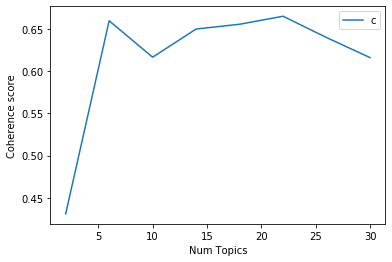

In [152]:
# Show graph
limit=32; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig(r'presentation/coherence_plot.png')
plt.show()

In [153]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.431
Num Topics = 6  has Coherence Value of 0.6594
Num Topics = 10  has Coherence Value of 0.6163
Num Topics = 14  has Coherence Value of 0.6496
Num Topics = 18  has Coherence Value of 0.6552
Num Topics = 22  has Coherence Value of 0.6647
Num Topics = 26  has Coherence Value of 0.6395
Num Topics = 30  has Coherence Value of 0.6158


In [157]:
# Can take a long time to run.
model_list2, coherence_values2 = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=18, limit=26, step=1)

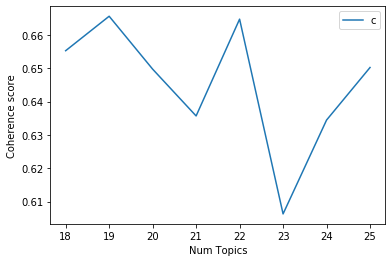

In [159]:
# Show graph
limit=26; start=18; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig(r'presentation/coherence_plot2.png')
plt.show()

In [160]:
# Print the coherence scores
for m, cv in zip(x, coherence_values2):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 18  has Coherence Value of 0.6552
Num Topics = 19  has Coherence Value of 0.6656
Num Topics = 20  has Coherence Value of 0.6497
Num Topics = 21  has Coherence Value of 0.6357
Num Topics = 22  has Coherence Value of 0.6647
Num Topics = 23  has Coherence Value of 0.6063
Num Topics = 24  has Coherence Value of 0.6344
Num Topics = 25  has Coherence Value of 0.6502


In [165]:
# Select the best model and print the topics
optimal_model = model_list2[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.161*"pittsburgh" + 0.112*"university" + 0.041*"program" + 0.027*"time" + '
  '0.021*"receive" + 0.019*"annual" + 0.018*"award" + 0.018*"fund" + '
  '0.018*"event" + 0.016*"student"'),
 (1,
  '0.054*"carnegie" + 0.038*"william" + 0.035*"home" + 0.025*"write" + '
  '0.024*"family" + 0.015*"frick" + 0.014*"business" + 0.013*"henry" + '
  '0.013*"letter" + 0.012*"foster"'),
 (2,
  '0.040*"window" + 0.026*"gothic" + 0.021*"delaporte" + 0.018*"figure" + '
  '0.016*"porch" + 0.014*"hand" + 0.013*"portal" + 0.013*"christ" + '
  '0.009*"head" + 0.008*"angel"'),
 (3,
  '0.087*"allegheny" + 0.064*"road" + 0.060*"park" + 0.058*"county" + '
  '0.046*"north" + 0.028*"pa" + 0.020*"west" + 0.018*"run" + 0.016*"house" + '
  '0.014*"city"'),
 (4,
  '0.087*"south" + 0.069*"north" + 0.066*"house" + 0.065*"side" + '
  '0.041*"pittsburgh" + 0.037*"city" + 0.033*"east" + 0.032*"hill" + '
  '0.026*"neighborhood" + 0.023*"work"'),
 (5,
  '0.020*"include" + 0.016*"series" + 0.014*"note" + 0.013*"paper

#### Create pyLDAvis with optimal_model

In [166]:
# Convert the class of the Mallet model into an LdaModel for pyLDAvis
vis_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [167]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(vis_model, corpus, id2word)
pyLDAvis.save_html(vis, 'presentation/lda-mallet_vis.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.028328  0.079801       1        1  8.578151
9     -0.185998 -0.173366       2        1  5.679364
6      0.039724 -0.044480       3        1  5.612433
10     0.170228 -0.075785       4        1  5.507782
8     -0.097251 -0.245856       5        1  5.480494
3     -0.213276  0.190248       6        1  5.246103
15    -0.187097  0.175529       7        1  5.223553
14     0.081441  0.089540       8        1  5.208940
7      0.093997 -0.087985       9        1  5.123086
18     0.108690 -0.056422      10        1  5.114402
12    -0.127469  0.133709      11        1  5.102709
5      0.124044 -0.081968      12        1  5.071873
4     -0.228927 -0.009858      13        1  5.047710
16     0.150537  0.059767      14        1  5.039387
1      0.070213 -0.026827      15        1  4.948224
0     -0.112484 -0.235391      16        1  4.690192
17     0.120849  0.073752      17        1  4.669401
13     0.102528  0.114283      18        1  4.551115
11     0.061925  0.121307      19        1  4.105081, topic_info=     Category          Freq        Term         Total  loglift  logprob
167   Default  21626.000000        pitt  21626.000000  30.0000  30.0000
749   Default  17486.000000      street  17486.000000  29.0000  29.0000
48    Default  19649.000000  pittsburgh  19649.000000  28.0000  28.0000
3126  Default   9889.000000        news   9889.000000  27.0000  27.0000
505   Default  10525.000000      avenue  10525.000000  26.0000  26.0000
...       ...           ...         ...           ...      ...      ...
885   Topic19    420.699722       black    678.999497   2.7142  -4.9131
1820  Topic19    218.440240    schedule    288.123803   2.9161  -5.5685
780   Topic19    292.264951     sponsor    542.305211   2.5748  -5.2773
2567  Topic19    250.801757     evening    407.259100   2.7082  -5.4303
1819  Topic19    225.519322      review    380.570651   2.6697  -5.5366

[1565 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
21601      9  0.850072   abramovic
3995       5  0.998832     academy
8182      16  1.003033     achieve
1023       4  0.721034      action
1023      15  0.277989      action
...      ...       ...         ...
18356     15  0.889475  zielmanksi
22793     13  0.892219     zongxin
2327       8  1.000416         zoo
18607     15  0.889475       zoola
24763     19  0.988829         zuo

[2133 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 10, 7, 11, 9, 4, 16, 15, 8, 19, 13, 6, 5, 17, 2, 1, 18, 14, 12])

#### Find dominant topic in each sentence (abstract)

In [192]:
sent_topics_df = pd.DataFrame()

In [193]:
# Get main topic in each document
for i, row in enumerate(optimal_model[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = optimal_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break
sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

In [194]:
sent_topics_df.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,7.0,0.0946,"play, theatre, present, thomas, display, class..."
1,10.0,0.1871,"worker, union, labor, caption, executive, stri..."
2,18.0,0.1192,"room, church, march, john, art, great, jame, w..."
3,17.0,0.1320,"mine, coal, violin, bulletin_index, row, healt..."
4,9.0,0.0788,"building, pittsburgh, construction, build, cen..."


In [195]:
sent_topics_df.shape

(124517, 3)

In [196]:
data_lda.head()

,Unnamed: 0,Unnamed: 0.1,Identifier,Title,Creator,Sort Date,Type of Resource,Genre,Abstract,Source,Site Membership,Collection Membership,Ttle_Abs,Abstract_cspell,Abstract_noc,Abstract_clean,Abstract_lemma
0,0,0,000001.PIC,Musicians,Paul Slantis,1950-01-01T00:00:00,still image,photograph,Six young African-American males playing percu...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,Musicians. Six young African-American males pl...,musicians. six young african-american males pl...,musicians. six young african-american males pl...,musicians six young african american males pla...,musician six young african american male play ...
1,1,1,000001.UE,Sylvania Locals Conference,United Electrical Workers,1945-04-29T00:00:00,still image,photograph,Leaders of Sylvania Locals. Front row (L-R): L...,"UE News Photograph Collection, 1933-1998UE New...","HistPitt, Digital",collection.89,Sylvania Locals Conference. Leaders of Sylvani...,sylvania locals conference. leaders of sylvani...,sylvania locals conference. leaders of sylvani...,sylvania locals conference leaders sylvania lo...,sylvania local conference leader sylvania loca...
2,2,2,000002.PIC,USMC Pilot with McDonnell FH Phantom,Paul Slantis,1950-01-01T00:00:00,still image,photograph,United States Marine Corps pilot with his McDo...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,USMC Pilot with McDonnell FH Phantom. United S...,usmc pilot with mcdonnell fh phantom. united s...,usmc pilot with mcdonnell fh phantom. united s...,usmc pilot mcdonnell fh phantom united states ...,usmc pilot mcdonnell fh phantom united state m...
3,3,3,000002.UE,Soup Kitchen,United Electrical Workers,1940-01-01T00:00:00,still image,photograph,Drinking donated coffee at Johnsonburg Plant S...,"UE News Photograph Collection, 1933-1998UE New...","HistPitt, Digital",collection.89,Soup Kitchen. Drinking donated coffee at Johns...,soup kitchen. drinking donated coffee at johns...,soup kitchen. drinking donated coffee at johns...,soup kitchen drinking donated coffee johnsonbu...,soup kitchen drink donate coffee johnsonburg p...
4,4,4,000003.PIC,Greater Pittsburgh International Airport Opening,Paul Slantis,1952-05-31T00:00:00,still image,photograph,US Navy airplanes lined up on the tarmac of th...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,Greater Pittsburgh International Airport Openi...,greater pittsburgh international airport openi...,greater pittsburgh international airport openi...,greater pittsburgh international airport openi...,great pittsburgh international airport open un...


In [197]:
data_lda.shape

(124517, 17)

In [198]:
unnamed_cols = data_lda.columns[data_lda.columns.str.startswith('Unnamed')]

In [199]:
data_df = data_lda.drop(unnamed_cols, axis=1)

In [200]:
data_df.head()

,Identifier,Title,Creator,Sort Date,Type of Resource,Genre,Abstract,Source,Site Membership,Collection Membership,Ttle_Abs,Abstract_cspell,Abstract_noc,Abstract_clean,Abstract_lemma
0,000001.PIC,Musicians,Paul Slantis,1950-01-01T00:00:00,still image,photograph,Six young African-American males playing percu...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,Musicians. Six young African-American males pl...,musicians. six young african-american males pl...,musicians. six young african-american males pl...,musicians six young african american males pla...,musician six young african american male play ...
1,000001.UE,Sylvania Locals Conference,United Electrical Workers,1945-04-29T00:00:00,still image,photograph,Leaders of Sylvania Locals. Front row (L-R): L...,"UE News Photograph Collection, 1933-1998UE New...","HistPitt, Digital",collection.89,Sylvania Locals Conference. Leaders of Sylvani...,sylvania locals conference. leaders of sylvani...,sylvania locals conference. leaders of sylvani...,sylvania locals conference leaders sylvania lo...,sylvania local conference leader sylvania loca...
2,000002.PIC,USMC Pilot with McDonnell FH Phantom,Paul Slantis,1950-01-01T00:00:00,still image,photograph,United States Marine Corps pilot with his McDo...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,USMC Pilot with McDonnell FH Phantom. United S...,usmc pilot with mcdonnell fh phantom. united s...,usmc pilot with mcdonnell fh phantom. united s...,usmc pilot mcdonnell fh phantom united states ...,usmc pilot mcdonnell fh phantom united state m...
3,000002.UE,Soup Kitchen,United Electrical Workers,1940-01-01T00:00:00,still image,photograph,Drinking donated coffee at Johnsonburg Plant S...,"UE News Photograph Collection, 1933-1998UE New...","HistPitt, Digital",collection.89,Soup Kitchen. Drinking donated coffee at Johns...,soup kitchen. drinking donated coffee at johns...,soup kitchen. drinking donated coffee at johns...,soup kitchen drinking donated coffee johnsonbu...,soup kitchen drink donate coffee johnsonburg p...
4,000003.PIC,Greater Pittsburgh International Airport Opening,Paul Slantis,1952-05-31T00:00:00,still image,photograph,US Navy airplanes lined up on the tarmac of th...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,Greater Pittsburgh International Airport Openi...,greater pittsburgh international airport openi...,greater pittsburgh international airport openi...,greater pittsburgh international airport openi...,great pittsburgh international airport open un...


In [201]:
df_topic_sents_keywords = pd.concat([data_df, sent_topics_df], axis=1)

In [202]:
df_topic_sents_keywords.shape

(124517, 18)

In [203]:
items_dominant_topics = df_topic_sents_keywords.reset_index()

In [204]:
items_dominant_topics.head()

,index,Identifier,Title,Creator,Sort Date,Type of Resource,Genre,Abstract,Source,Site Membership,Collection Membership,Ttle_Abs,Abstract_cspell,Abstract_noc,Abstract_clean,Abstract_lemma,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,0,000001.PIC,Musicians,Paul Slantis,1950-01-01T00:00:00,still image,photograph,Six young African-American males playing percu...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,Musicians. Six young African-American males pl...,musicians. six young african-american males pl...,musicians. six young african-american males pl...,musicians six young african american males pla...,musician six young african american male play ...,7.0,0.0946,"play, theatre, present, thomas, display, class..."
1,1,000001.UE,Sylvania Locals Conference,United Electrical Workers,1945-04-29T00:00:00,still image,photograph,Leaders of Sylvania Locals. Front row (L-R): L...,"UE News Photograph Collection, 1933-1998UE New...","HistPitt, Digital",collection.89,Sylvania Locals Conference. Leaders of Sylvani...,sylvania locals conference. leaders of sylvani...,sylvania locals conference. leaders of sylvani...,sylvania locals conference leaders sylvania lo...,sylvania local conference leader sylvania loca...,10.0,0.1871,"worker, union, labor, caption, executive, stri..."
2,2,000002.PIC,USMC Pilot with McDonnell FH Phantom,Paul Slantis,1950-01-01T00:00:00,still image,photograph,United States Marine Corps pilot with his McDo...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,USMC Pilot with McDonnell FH Phantom. United S...,usmc pilot with mcdonnell fh phantom. united s...,usmc pilot with mcdonnell fh phantom. united s...,usmc pilot mcdonnell fh phantom united states ...,usmc pilot mcdonnell fh phantom united state m...,18.0,0.1192,"room, church, march, john, art, great, jame, w..."
3,3,000002.UE,Soup Kitchen,United Electrical Workers,1940-01-01T00:00:00,still image,photograph,Drinking donated coffee at Johnsonburg Plant S...,"UE News Photograph Collection, 1933-1998UE New...","HistPitt, Digital",collection.89,Soup Kitchen. Drinking donated coffee at Johns...,soup kitchen. drinking donated coffee at johns...,soup kitchen. drinking donated coffee at johns...,soup kitchen drinking donated coffee johnsonbu...,soup kitchen drink donate coffee johnsonburg p...,17.0,0.1320,"mine, coal, violin, bulletin_index, row, healt..."
4,4,000003.PIC,Greater Pittsburgh International Airport Opening,Paul Slantis,1952-05-31T00:00:00,still image,photograph,US Navy airplanes lined up on the tarmac of th...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,Greater Pittsburgh International Airport Openi...,greater pittsburgh international airport openi...,greater pittsburgh international airport openi...,greater pittsburgh international airport openi...,great pittsburgh international airport open un...,9.0,0.0788,"building, pittsburgh, construction, build, cen..."


In [205]:
items_dominant_topics.shape

(124517, 19)

#### Topic distribution across items

In [206]:
topics = pd.DataFrame()
topics = pd.DataFrame(items_dominant_topics.Topic_Keywords.unique(), columns=['Topic_Keywords'])
topics

,Topic_Keywords
0,"play, theatre, present, thomas, display, class..."
1,"worker, union, labor, caption, executive, stri..."
2,"room, church, march, john, art, great, jame, w..."
3,"mine, coal, violin, bulletin_index, row, healt..."
4,"building, pittsburgh, construction, build, cen..."
5,"pennsylvania, senator_specter, pa, western, an..."
6,"general, map, washington, plan, state, george,..."
7,"south, north, house, side, pittsburgh, city, e..."
8,"man, woman, front, child, group, portrait, sig..."
9,"allegheny, road, park, county, north, pa, west..."


In [207]:
Keywords = pd.DataFrame(items_dominant_topics.Topic_Keywords.unique(), columns=['Topic_Keywords'])
Topic_Num = pd.DataFrame(items_dominant_topics.Dominant_Topic.unique(), columns=['Topic_Num'])
topics = pd.concat([Topic_Num, Keywords], axis=1)
topics

,Topic_Num,Topic_Keywords
0,7.0,"play, theatre, present, thomas, display, class..."
1,10.0,"worker, union, labor, caption, executive, stri..."
2,18.0,"room, church, march, john, art, great, jame, w..."
3,17.0,"mine, coal, violin, bulletin_index, row, healt..."
4,9.0,"building, pittsburgh, construction, build, cen..."
5,13.0,"pennsylvania, senator_specter, pa, western, an..."
6,16.0,"general, map, washington, plan, state, george,..."
7,4.0,"south, north, house, side, pittsburgh, city, e..."
8,14.0,"man, woman, front, child, group, portrait, sig..."
9,3.0,"allegheny, road, park, county, north, pa, west..."


In [208]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Merge on Dominant_Topic
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Prop_Documents']

df_dominant_topics['Dominant_Topic'] = df_dominant_topics.index

In [209]:
df_dominant_topics

,Num_Documents,Prop_Documents,Dominant_Topic
11.0,17076,0.1371,11.0
13.0,10590,0.0850,13.0
0.0,10174,0.0817,0.0
17.0,10090,0.0810,17.0
15.0,8005,0.0643,15.0
5.0,7578,0.0609,5.0
12.0,7351,0.0590,12.0
1.0,6173,0.0496,1.0
10.0,5531,0.0444,10.0
16.0,4962,0.0398,16.0


In [210]:
items_topics_summ = pd.merge(topics,
    df_dominant_topics[['Num_Documents', 'Prop_Documents', 'Dominant_Topic']],
    left_on='Topic_Num', 
    right_on='Dominant_Topic',
    how='left')

In [211]:
items_topics_summ.drop(['Dominant_Topic'], inplace = True, axis=1)

In [212]:
items_topics_summ.head(10)

,Topic_Num,Topic_Keywords,Num_Documents,Prop_Documents
0,7.0,"play, theatre, present, thomas, display, class...",4921,0.0395
1,10.0,"worker, union, labor, caption, executive, stri...",5531,0.0444
2,18.0,"room, church, march, john, art, great, jame, w...",3950,0.0317
3,17.0,"mine, coal, violin, bulletin_index, row, healt...",10090,0.0810
4,9.0,"building, pittsburgh, construction, build, cen...",3192,0.0256
5,13.0,"pennsylvania, senator_specter, pa, western, an...",10590,0.0850
6,16.0,"general, map, washington, plan, state, george,...",4962,0.0398
7,4.0,"south, north, house, side, pittsburgh, city, e...",4078,0.0328
8,14.0,"man, woman, front, child, group, portrait, sig...",4445,0.0357
9,3.0,"allegheny, road, park, county, north, pa, west...",4148,0.0333


### Write items_topics_summ and items_dominant_topics to csv to name topics

In [189]:
items_topics_summ.to_csv(r'items_topics_summ.csv')

### Manually add columns Topic_Num_Vis and Topic_Name
Topic numbers on graph are different from those output by Mallet.<BR>
Add Topic_Num_Vis column to track dominant topic number from the pyLDAvis interactive graph.<BR>
These mappings will change if the data preparation changes and the model is re-run.<BR>
Review graph and items_dominant_topics titles and abstracts to name the topics.

### Read topic summary csv file after adding Topic_Num_Vis

In [213]:
# Load data with topics
pd.set_option('display.max_columns', None)
topics = pd.read_csv('items_topics_summ.csv', encoding='latin-1')

# Display the head
topics.head()

,Unnamed: 0,Topic_Num,Topic_Num_Vis,Topic_Name,Topic_Keywords,Num_Documents,Prop_Documents
0,0,7,9,NaN,"play, theatre, present, thomas, display, class...",4921,0.0395
1,1,10,4,Unions and Labor; Political and Economic Ideal...,"worker, union, labor, caption, executive, stri...",5531,0.0444
2,2,18,10,NaN,"room, church, march, john, art, great, jame, w...",3950,0.0317
3,3,17,17,NaN,"mine, coal, violin, bulletin_index, row, healt...",10090,0.0810
4,4,9,2,"Buildings: History, Construction, Restoration,...","building, pittsburgh, construction, build, cen...",3192,0.0256


### Add Dominant_Topic_Vis to items_dominant_topics dataset

In [214]:
items_dominant_topics['Dominant_Topic_Vis']=items_dominant_topics.Dominant_Topic.map(topics.set_index('Topic_Num').Topic_Num_Vis)

### Write items dominant topics data to file

In [215]:
items_dominant_topics.to_csv(r'items_dominant_topics.csv')

### Find the most representative document (abstract) for each topic

In [216]:
# Load data with topics
pd.set_option('display.max_columns', None)
data_topics = pd.read_csv('items_dominant_topics.csv', encoding='latin-1')

# Display the head
data_topics.head()

,Unnamed: 0,index,Identifier,Title,Creator,Sort Date,Type of Resource,Genre,Abstract,Source,Site Membership,Collection Membership,Ttle_Abs,Abstract_cspell,Abstract_noc,Abstract_clean,Abstract_lemma,Dominant_Topic,Perc_Contribution,Topic_Keywords,Dominant_Topic_Vis
0,0,0,000001.PIC,Musicians,Paul Slantis,1950-01-01T00:00:00,still image,photograph,Six young African-American males playing percu...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,Musicians. Six young African-American males pl...,musicians. six young african-american males pl...,musicians. six young african-american males pl...,musicians six young african american males pla...,musician six young african american male play ...,7.0,0.0946,"play, theatre, present, thomas, display, class...",9
1,1,1,000001.UE,Sylvania Locals Conference,United Electrical Workers,1945-04-29T00:00:00,still image,photograph,Leaders of Sylvania Locals. Front row (L-R): L...,"UE News Photograph Collection, 1933-1998UE New...","HistPitt, Digital",collection.89,Sylvania Locals Conference. Leaders of Sylvani...,sylvania locals conference. leaders of sylvani...,sylvania locals conference. leaders of sylvani...,sylvania locals conference leaders sylvania lo...,sylvania local conference leader sylvania loca...,10.0,0.1871,"worker, union, labor, caption, executive, stri...",4
2,2,2,000002.PIC,USMC Pilot with McDonnell FH Phantom,Paul Slantis,1950-01-01T00:00:00,still image,photograph,United States Marine Corps pilot with his McDo...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,USMC Pilot with McDonnell FH Phantom. United S...,usmc pilot with mcdonnell fh phantom. united s...,usmc pilot with mcdonnell fh phantom. united s...,usmc pilot mcdonnell fh phantom united states ...,usmc pilot mcdonnell fh phantom united state m...,18.0,0.1192,"room, church, march, john, art, great, jame, w...",10
3,3,3,000002.UE,Soup Kitchen,United Electrical Workers,1940-01-01T00:00:00,still image,photograph,Drinking donated coffee at Johnsonburg Plant S...,"UE News Photograph Collection, 1933-1998UE New...","HistPitt, Digital",collection.89,Soup Kitchen. Drinking donated coffee at Johns...,soup kitchen. drinking donated coffee at johns...,soup kitchen. drinking donated coffee at johns...,soup kitchen drinking donated coffee johnsonbu...,soup kitchen drink donate coffee johnsonburg p...,17.0,0.1320,"mine, coal, violin, bulletin_index, row, healt...",17
4,4,4,000003.PIC,Greater Pittsburgh International Airport Opening,Paul Slantis,1952-05-31T00:00:00,still image,photograph,US Navy airplanes lined up on the tarmac of th...,"Paul Slantis Photograph Collection, ca. 1946-1...","HistPitt, Digital",collection.68,Greater Pittsburgh International Airport Openi...,greater pittsburgh international airport openi...,greater pittsburgh international airport openi...,greater pittsburgh international airport openi...,great pittsburgh international airport open un...,9.0,0.0788,"building, pittsburgh, construction, build, cen...",2


In [217]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = data_topics.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Show
sent_topics_sorteddf_mallet.head()

,Unnamed: 0,index,Identifier,Title,Creator,Sort Date,Type of Resource,Genre,Abstract,Source,Site Membership,Collection Membership,Ttle_Abs,Abstract_cspell,Abstract_noc,Abstract_clean,Abstract_lemma,Dominant_Topic,Perc_Contribution,Topic_Keywords,Dominant_Topic_Vis
0,102770,102770,PCW000113,Mountain Day picnic,Unknown,1923-10-05T00:00:00,still image,photograph,"On Mountain Day 1923, students enjoy lunch on ...",Chatham University Chronological Photograph Fi...,HistPitt,collection.236,"Mountain Day picnic. On Mountain Day 1923, stu...","mountain day picnic. on mountain day 1923, stu...","mountain day picnic. on mountain day 1923, stu...",mountain day picnic mountain day 1923 students...,mountain day picnic mountain day 1923 student ...,0.0,0.5384,"pittsburgh, university, program, time, receive...",16
1,9183,9183,20100329-ocl-0646,Extended Cooper Family,Dr. W.H. Cooper Family,1906-08-01T00:00:00,still image,photograph,"The entire Cooper family poses at Allen House,...",Caroline Carroll Image CollectionCaroline Carr...,"HistPitt, Digital",collection.65,Extended Cooper Family. The entire Cooper fami...,extended cooper family. the entire cooper fami...,extended cooper family. the entire cooper fami...,extended cooper family entire cooper family po...,extend cooper family entire cooper family pose...,1.0,0.6872,"carnegie, william, home, write, family, frick,...",15
2,95653,95653,FCSP18102000,Scenes 1 - 4,NaN,NaN,still image,art,"Gothic|||West FaÃÂÃÂade, Left Frieze, Life...",chartres,Digital,collection.127,"Scenes 1 - 4. Gothic|||West FaÃÂÃÂade, Lef...","scenes 1-4. gothic west faÃÂ¢ÃÂade, left fr...","scenes 1-4. gothic west faÃÂ¢ÃÂade, left fr...",scenes 1 4 gothic west fa ade left frieze life...,scene 1 4 gothic west fa ade leave frieze life...,2.0,0.7805,"window, gothic, delaporte, figure, porch, hand...",1
3,10574,10574,20120009-hpicnpl-0009,1936 Aerial Image - Franklin Township - Camp m...,Allegheny County Department of Public Works,1936-01-01T00:00:00-05:00,still image,photograph,1936 aerial view of Franklin Township (now Fra...,hpicnplAllegheny County Department of Public W...,HistPitt,collection.64,1936 Aerial Image - Franklin Township - Camp m...,1936 aerial image-franklin township-camp meeti...,1936 aerial image-franklin township-camp meeti...,1936 aerial image franklin township camp meeti...,1936 aerial image franklin township camp meeti...,3.0,0.4950,"allegheny, road, park, county, north, pa, west...",6
4,120266,120266,PSS6.B007.I17,John Peeples,Cargo's Photographic Rooms,1862-01-01T00:00:00,still image,photograph,"John Peeples worked for Lyon, Shorb & Company,...","Lyon, Shorb & Company Photographs, ca. 1863-18...",HistPitt,collection.59,"John Peeples. John Peeples worked for Lyon, Sh...","john peeples. john peeples worked for lyon, sh...","john peeples. john peeples worked for lyon, sh...",john peeples john peeples worked lyon shorb co...,john peeple john peeple work lyon shorb compan...,4.0,0.4153,"south, north, house, side, pittsburgh, city, e...",13


#### Write most representative item data to file

In [218]:
sent_topics_sorteddf_mallet.to_csv(r'items_most_relevant.csv')